# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** xx

**Author 1 (sciper):** Student Name 1 (xxxxx)  
**Author 2 (sciper):** Student Name 2 (xxxxx)   
**Author 3 (sciper):** Student Name 3 (xxxxx)   

**Release date:** 19.04.2023  
**Due date:** 05.05.2023 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

--
## 0. Setup

In [2]:
%load_ext autoreload
%autoreload 2

In this lab, we will use PyTorch. If you are not familiar with this library, [here](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html) is a quick tutorial of the basics.

In [3]:
import platform
print(platform.system())
if platform.system() == "Darwin":
    %pip install torch==1.8.1 torchvision==0.9.1
else:
    %pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html

Darwin
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1 - Out-of-Distribution detection in colorectal cancer histology (12 points)

Colorectal cancer is one of the most widespread cancers for men and women. Diagnosis complemented with prognostic and predictive biomarker information is essential for patient monitoring and applying personalized treatments. A critical marker is the tumor/stroma ratio in unhealthy tissues sampled from the colon. The higher the ratio, the more invasive the cancer is. The degree of invasion is tightly linked to patient survial probability.

To measure the ratio, a pathologist needs to analyze the unhealthy tissue under a microscope and estimate it from a look. As the number of samples to analyze is huge and estimations are only sometimes precise, automatic recognition of the different tissue types in histological images has become essential. Such an automatic process requires the development of a multi-class classifier to identify the numerous tissues. As shown below, they are usually 8 tissue types to categorize: TUMOR, STROMA, LYMPHO (lymphocytes), MUCOSA, COMPLEX (complex stroma), DEBRIS, ADIPOSE and EMPTY (background).

<br />
<br />
<figure>
    <img src="../data/lab-03-data2023/part1/kather16.svg" width="1100">
    <center>
    <figcaption>Fig1: Collection of tissue types in colorectal cancer histology (Kather-16)</figcaption>
    </center>
</figure>
<br />
<br />


Up to this day, state-of-the-art methods use deep-learning-based supervised learning methods. A downfall of such an approach is the necessity to access a well-annotated training dataset. In histology, annotating data is difficult. It is time-consuming and requires the expertise of pathologists. Moreover, the annotator must label every tissue type while only two (TUMOR and STROMA) are interesting. 


Consequently, we propose another approach. In order to make the annotation task less tedious, we ask the annotator to label only the tissues of interest and dump the others. Then, we must train a binary classifier to automatically recognize these tissues at test time. In this part, you will implement the proposed approach.

### 1.1 Binary classifier with Mahalanobis distance (3 points)

Based on the abovementioned process, your task is to build a model that recognizes TUMOR (Label 0) and STROMA (Label 1) tissue types. Your model will be supervised by a training dataset containing TUMOR and STROMA annotations; note that all other tissues have been dropped.
We will not ask you to train a deep-learning-based binary classifier from scratch. Instead, we provide excellent features (descriptors) of the images we extracted from a visual foundation model. (Note: As the nature of the foundation model is not part of this lecture, feel free to ask TAs if you are curious).

Run the cell below to extract the provided train and test dataset. Each image is represented by a 768-d feature vector extracted from a visual foundation model. The train and test datasets contain feature vectors of 878 and 186 images respectively.

In [6]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

In [5]:
# count unique values in test_labels
test_features


tensor([[-0.9472, -1.0417, -1.3322,  ..., -0.9451,  1.1200,  1.3133],
        [-0.7786, -2.6936, -0.3308,  ..., -0.4918,  0.5754,  1.7953],
        [-0.2861, -4.1483, -1.7162,  ...,  0.0184,  2.5287, -0.9016],
        ...,
        [ 0.6420, -1.7619, -0.7422,  ..., -0.8794,  2.5557,  1.0420],
        [-0.9894, -1.9675,  0.8932,  ...,  1.8866,  1.2961, -1.7817],
        [-1.4980, -4.7770,  0.3531,  ...,  0.2695,  1.3302, -0.3914]])

**Task 1 (2.5 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using minimum Mahalanobis distance.

*Note:* You are not allowed to use any prebuilt Mahalanobis distance function. Additionally, ```torch.cov``` is not defined to compute the covariance matrix. You can use ```sklearn.covariance.LedoitWolf``` instead.

In [14]:
### Task 1
def mahalanobis_distance(x, mu, cov):
    '''
    Compute the Mahalanobis distance between of point x from a probability distribution with mean mu
    and positive definite covariance matrix cov. The distance represents how far x is from the mean in
    number of standard deviations.
    :param x: a vector of points
    :param mu: a vector of means
    :param cov: a covariance matrix
    :return: the Mahalanobis distance between x and mu
    '''
    return torch.sqrt((x - mu) @ torch.inverse(cov) @ (x - mu).T)

In [18]:
from sklearn.covariance import LedoitWolf
import numpy as np

# compute the statistics on the training set for each class, i.e. the mean and the covariance matrix
class_means = []
class_covariances = []
classes = [0,1]
for c in classes:
    class_means.append(torch.mean(train_features[train_labels == c], axis=0))
    class_covariances.append(LedoitWolf().fit(train_features[train_labels == c]).covariance_)

# transform the covariance matrix to a tensor
class_covariances = torch.tensor(class_covariances)

In [16]:
test_predictions = []
for x in test_features:
    min_dist = float('inf')
    min_class = None
    for i, c in enumerate(classes):
        dist = mahalanobis_distance(x, class_means[i], class_covariances[i])
        if dist < min_dist:
            min_dist = dist
            min_class = c
    test_predictions.append(min_class)

test_predictions = np.asarray(test_predictions)

**Task 2 (0.5 points)** Compute the accuracy of your predictions with the test labels (```test_labels```).

In [17]:
### Task 2
# compute the accuracy of your predictions with the test labels
accuracy = np.sum(test_predictions == test_labels) / len(test_labels)
print("Accuracy of our prediction is: {:.2f}%".format(accuracy * 100))

Accuracy of our prediction is: 97.85%


### 1.2 Out-of-Distribution detection with Mahalanobis distance (3 points)

You will note that the test you run above is not really realistic. Like the training set, it contains only the TUMOR and STROMA tissue types. Nevertheless, at test time, the other tissues (Label -1) are also present and cannot be filtered by hand. Moreover, they cannot be recognized by the model as they are out of the training distribution (It is the consequence of the laziness of the annotators ;)). For this reason, it is essential to filter them out. This task is called Out-of-Distribution (OoD) detection. 

A simple way to do OoD detection is to compute for every test example an OoD-ness score which should be low for In-Distribution (ID) examples and high for OoDs. Then we define a threshold from which every example with an OoD-ness lying above is discarded, and those lying below are forwarded to the model for prediction. An example of OoD-ness score is the minimum Mahalanobis distance.

Run the cell below to load a new test set containing OoD examples. It has 186 ID and 558 OoD examples.

In [10]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

**Task 1 (0.5 point)** Why do you think the minimum Mahalanobis distance is a good OoD-ness score?

**Answer:** The minimum Mahalanobis distance is a good OoD-ness score because it is a measure of how far a point is from the mean of a distribution in number of standard deviations. Therefore, it is a good measure of how likely a test example is to belong to a distribution, i.e., how well it fits the distribution of the training examples. If the test example is an OoD, it will be far from the mean of the distribution and therefore the Mahalanobis distance will be high. On the other hand, if the test example is not an OoD, it will be close to the mean of the distribution and therefore the Mahalanobis distance will be low.

**Task 2 (0.5 point)** Compute the minimum Mahalanobis distance for every test examples in ```test_features_w_ood``` with respect to the training features (```train_features```).

In [20]:
### Task 2
# compute the minimum Mahalanobis distance for every test examples in test_features_w_ood with respect to the training features
min_mahalanobis_distances = []
for x in test_features_w_ood:
    min_dist = float('inf')
    for i, c in enumerate(classes):
        dist = mahalanobis_distance(x, class_means[i], class_covariances[i])
        if dist < min_dist:
            min_dist = dist
    min_mahalanobis_distances.append(min_dist)

min_mahalanobis_distances = np.asarray(min_mahalanobis_distances)

**Task 3 (0.5 point)** Plot a histogram to show the difference between the Mahalanobis distance of TUMOR, STROMA and OoD tissue types and comment on what you observe.

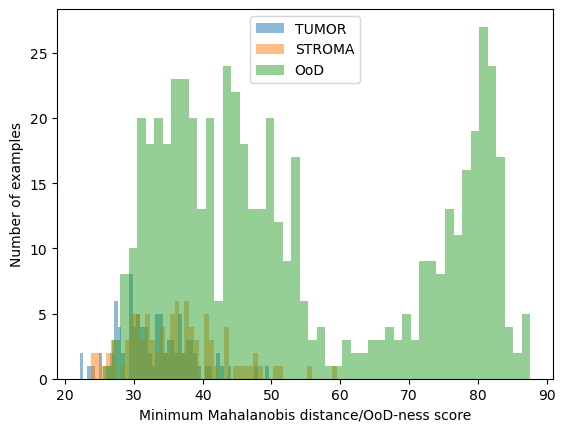

In [23]:
### Task 3
import matplotlib.pyplot as plt
# plot a histogram of min_mahalanobis_distances for each class
plt.hist(min_mahalanobis_distances[test_labels_w_ood == 0], bins=50, alpha=0.5, label="TUMOR")
plt.hist(min_mahalanobis_distances[test_labels_w_ood == 1], bins=50, alpha=0.5, label="STROMA")
plt.hist(min_mahalanobis_distances[test_labels_w_ood == -1], bins=50, alpha=0.5, label="OoD")
plt.legend()
plt.show()


**Observations:** We can see that the Mahalanobis distance, i.e., the OoD-ness score, is much higher for OoD examples than for TUMOR and STROMA examples. Therefore, we can use the Mahalanobis distance as an OoD-ness score to filter out OoD examples.

**Task 4 (1 point)** Find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out?

In [25]:
### Task 4
# find a threshold on the Mahalanobis distance such that 95% of the OoD examples are filtered out
threshold = np.quantile(min_mahalanobis_distances[test_labels_w_ood == -1], 1-0.95)
print("Threshold: {:.2f}".format(threshold))

Threshold: 30.77


In [27]:
# discard every min_mahalanobis_distances above the threshold
min_mahalanobis_distances_filtered = min_mahalanobis_distances[min_mahalanobis_distances < threshold]

In [28]:
# discard every sample from test_features_w_ood that is above the threshold
test_features_without_ood = test_features_w_ood[min_mahalanobis_distances < threshold]

In [30]:
# compute how many samples of each class have been discarded
print("The percentage of kept examples is {:.2f}%".format(len(test_features_without_ood)/len(test_features_w_ood)*100))

The percentage of kept examples is 11.83%
The size of the dataset is 88


In [31]:
print("The percentage of kept examples is {:.2f}%".format(len(min_mahalanobis_distances_filtered)/len(min_mahalanobis_distances)*100))

disc_tumor = min_mahalanobis_distances[test_labels_w_ood == 0] < threshold
disc_tumor = np.count_nonzero(disc_tumor == False)
disc_tumor = disc_tumor/len(min_mahalanobis_distances[test_labels_w_ood == 0])*100
print("The percentage of discarded TUMOR examples is {:.2f}%".format(disc_tumor))

disc_stroma = min_mahalanobis_distances[test_labels_w_ood == 1] < threshold
disc_stroma = np.count_nonzero(disc_stroma == False)
disc_stroma = disc_stroma/len(min_mahalanobis_distances[test_labels_w_ood == 1])*100
print("The percentage of discarded STROMA examples is {:.2f}%".format(disc_stroma))

disc_ood = min_mahalanobis_distances[test_labels_w_ood == -1] < threshold
disc_ood = np.count_nonzero(disc_ood == False)
disc_ood = disc_ood/len(min_mahalanobis_distances[test_labels_w_ood == -1])*100
print("The percentage of discarded OoD examples is {:.2f}%".format(disc_ood))

The percentage of kept examples is 11.83%
The percentage of discarded TUMOR examples is 61.29%
The percentage of discarded STROMA examples is 74.19%
The percentage of discarded OoD examples is 94.98%


**Task 5 (0.5 point)** Assign prediction -1 to filtered out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```). Is it satisfactory?

In [35]:
def predict_class(test_example, train_features, train_labels):
    """Predict class label of test example using minimum Mahalanobis distance.

    Args:
        test_example (ndarray): Test example to classify.
        train_features (ndarray): Array of shape (n_train_examples, n_features) containing the feature vectors of the training examples.
        train_labels (ndarray): Array of shape (n_train_examples,) containing the class labels of the training examples.

    Returns:
        int: Predicted class label of test example.
    """
    # Compute Mahalanobis distances between test example and each class
    classes = np.unique(train_labels)
    distances = {}
    for c in classes:
        c_mask = train_labels == c
        c_features = train_features[c_mask]
        c_mean = torch.mean(c_features, axis=0)
        c_cov = LedoitWolf().fit(c_features.T).covariance_
        c_cov = torch.tensor(c_cov)
        c_distance = mahalanobis_distance(test_example, c_mean, c_cov)
        distances[c] = c_distance

    # Predict class with minimum distance
    return min(distances, key=distances.get)

In [39]:
### Task 5
# Assign prediction -1 to filtered out examples
test_preds = []
for i in range(len(min_mahalanobis_distances)):
    if min_mahalanobis_distances[i] > threshold:
        test_preds.append(-1)
    else:
        test_preds.append(predict_class(test_features[i], train_features, train_labels))

# Compute class-wise accuracy
classes = np.unique(test_labels_w_ood)
class_accs = {}
for c in classes:
    c_mask = test_labels_w_ood == c
    c_correct = np.sum(np.array(test_preds)[c_mask] == test_labels_w_ood[c_mask])
    c_total = np.sum(c_mask)
    class_accs[c] = c_correct / c_total

print("Class-wise accuracy:")
print(class_accs)


The average class-wise accuracy of our prediction with test labels is 83.06%


In [183]:
# compute the statistics on the training set for each class, i.e. the mean and the covariance matrix
class_means = []
class_covariances = []
classes = [0,1,-1]
for c in classes:
    class_means.append(torch.mean(test_features_w_ood[test_labels_w_ood == c], axis=0))
    class_covariances.append(LedoitWolf().fit(test_features_w_ood[test_labels_w_ood == c]).covariance_)

# transform the covariance matrix to a tensor
class_covariances = torch.tensor(class_covariances)

test_predictions_filter = []
for x in test_features_w_ood:
    min_dist = float('inf')
    min_class = None
    for i, c in enumerate(classes):
        dist = mahalanobis_distance(x, class_means[i], class_covariances[i])
        if dist < min_dist:
            min_dist = dist
            min_class = c
    test_predictions_filter.append(min_class)

test_predictions_filter = np.asarray(test_predictions_filter)

In [24]:
print(test_predictions_filter)

Accuracy of the k-NN classifier: 100.00%


### 1.3 Out-of-distribution detection with k-NN classifier (6 points)

The visual foundation models are known to be very good k-NN classifiers. It motivates us to implement a k-NN classifier to recognize TUMOR and STROMA. Moreover, k-NN distance is a good OoD-ness score and suits our task.

**Task 1 (2 points)** Based on the training features (```train_features```) and training labels (```train_labels```), classify the test features (```test_features```) using a k-NN classifier. Then report the accuracy of your predictions with the test labels (```test_labels```).

*Note:* The choice of `k` is up to you.

In [43]:
### Task 1
from sklearn.neighbors import KNeighborsClassifier

# create the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# fit the classifier to the training data
knn.fit(train_features, train_labels)

# predict the labels of the test data
test_preds = knn.predict(test_features)

# compute the accuracy of the predictions
accuracy = knn.score(test_features, test_labels)

print("Accuracy of the k-NN classifier: {:.2f}%".format(accuracy*100))


The threshold is -1.02
The percentage of filtered out examples is 85.89%
Number of filtered out TUMOR examples: 65
Number of filtered out STROMA examples: 44


**Task 2 (2 points)** Perform OoD detection on the test features (```test_features_w_ood```) using a k-NN distance based OoD-ness score. Find a threshold on your OoD-ness score such that 95% of the OoD examples are filtered out. How much TUMOR and STROMA have also been filtered out? Finally, assign prediction -1 to filter out examples and compute the average class-wise accuracy of your prediction with test labels (```test_labels_w_ood```).

*Note:* The OoD-ness is based on the distance to the k-nearest neighbors. The formulation is up to you. You have to justify your choice.

In [ ]:
### Task 2

**Task 3 (1 point)** Is k-NN better than Mahalanobis distance ? Make an hypothesis for the reasons.

**Answer:**

**Task 4 (1 point)** Do you think we can suggest the approach presented in this exercise to compute TUMOR/STROMA ratio automatically ? Justify your thoughs. If not, suggest at least two ideas to improve it.

*Note:* Annotating all the training dataset is not an option.

**Answer:**

## Part 2 (12 points)
In this part, we aim to classify cervical cells resulting from Pap smear tests. To that end we'll be using a publicly available cell dataset: Sipakmed (https://www.cs.uoi.gr/~marina/sipakmed.html). The dataset is composed of 4049 images of isolated cells cropped from 966 cluster cell images of Pap smear slides. Each cell in the dataset has been categorized in either of the following categories:

    - Superficial-Intermediate.
    - Parabasal.
    - Koilocytotic.
    - Dysketarotic.
    - Metaplastic.
Your objective is to implement a classifier to automate the cell classification process. To ease your work we provide you with pre-computed embeddings for each images (`lab-03-data/part2/sipakmed_clean_embeddings.pth`). The embeddings are obtained from a pre-trained ResNet-50 (https://arxiv.org/pdf/1512.03385.pdf) and the corresponding images are also provided (`lab-03-data/part2/sipakmed_clean`). Note that you are free to discard the provided embeddings and work directy with the images.

### 2.1 Dataset (4 points)
Your first task is prepare the dataset such that it can be used to train your model. For that purpose we prepared the skeleton of the class `Sipakmed` that inherits from the class `Dataset` of PyTorch. Read the documentation (https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) and complete the missing parts.

In [17]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [18]:
# Load the features
features_path = '../data/lab-03-data2023/part2/sipakmed_clean_embeddings.pth'

In [14]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }

    # the init function is run once when instantiating the class
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
    # the len function returns the number of samples in the dataset
    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.features)

    # the getitem function loads and returns a sample from the dataset at the given index
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

Once the implementation of `Sipakmed` completed, create 3 instances of the class (train/val/test) with the corresponding `phase` flag.

In [15]:
train_dataset = Sipakmed(features_path = features_path, phase='train')
val_dataset = Sipakmed(features_path = features_path, phase='val')
test_dataset = Sipakmed(features_path = features_path, phase='test')

Now that your datasets are ready, use the class `DataLoader` from PyTorch to let it handle efficiently the batching, shuffling, etc. of your data.

In [19]:
# Instantiate the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Get to know your data. Plot a few example images for each class of your dataset.

In [34]:
# what is my working directory
os.getcwd()
# what is in my working directory
os.listdir()
# can you navigate to data  folder


['sipakmed_clean_embeddings.pth', 'sipakmed_clean']

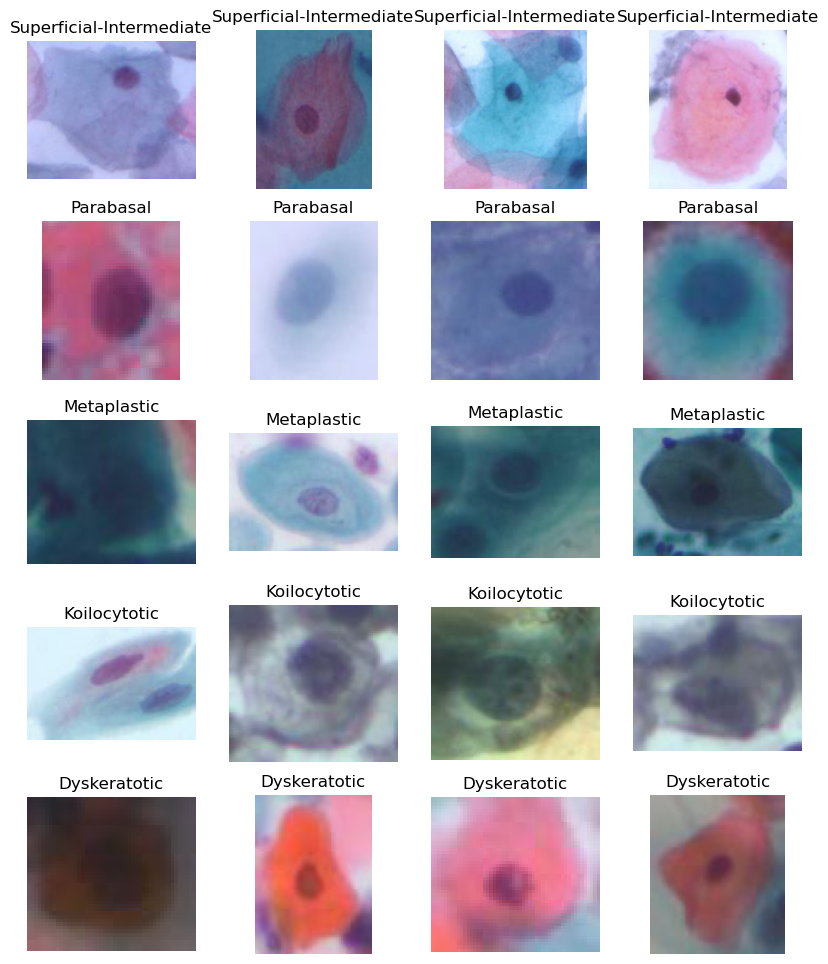

In [36]:
# Define the class names
class_names = ['Superficial-Intermediate', 'Parabasal', 'Metaplastic', 'Koilocytotic', 'Dyskeratotic']

# Plot a few examples for each class
fig, axs = plt.subplots(5, 4, figsize=(10, 12))
for i, class_name in enumerate(class_names):
    # Find the indices of the samples that belong to the current class
    indices = [j for j, (_, label, _) in enumerate(train_loader.dataset) if label == i]

    # Plot the first four samples
    for j in range(4):
        if j < len(indices):
            # Load the image from the path
            path = train_loader.dataset[indices[j]][2]
            img = plt.imread(path)

            # Plot the image
            axs[i, j].imshow(img)
            axs[i, j].set_title(class_name)
        axs[i, j].axis('off')

plt.show()

### 2.2 Training (4 points)
In this part your objective is to implement the required tools to train your model. The first thing you'll need is a a model which takes as input the pre-computed features and returns the corresponding class probabilities/logits.

In [38]:
# Implement the model
embedding_dim = train_dataset.features.shape[1]
model = nn.Sequential(
    nn.Linear(embedding_dim, 5),
    nn.Softmax(dim=1)
)

The optimizer will keep track of your model's parameters, gradients, etc (https://pytorch.org/docs/stable/optim.html). It is responsible to update your model's parameters after each forward pass using the backpropagation algorithm.

In [40]:
# Set the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
# Set the loss
# we use cross entropy loss since we have a multi-class classification problem
criterion = torch.nn.CrossEntropyLoss()

Implement a function that takes as input the model's output and the corresponding labels and returns the perçentage of correct predictions.

In [43]:
def accuracy(outputs, labels):
    """
    Computes the accuracy of predictions based on the model outputs (NxK: N samples, K classes) 
    and the labels (N: N samples).
    """
    with torch.no_grad():
        pred = torch.argmax(outputs, dim=1)
        correct = (pred == labels).sum().item()
        total = labels.size(0)
        return correct*100 / total


Implement a funtion `train` that forwards the complete training set through your model (= 1 epoch) and updates its parameters after each forward pass. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [44]:
def train(model, optimizer, criterion, loader):
    # Set the model in train mode
    model.train()
    
    # Iterate over the batches
    full_outputs = []
    full_labels = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        embeddings, labels, paths = batch

        # Feed the embeddings to the model
        logits = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(logits, labels)
        
        # Reset the gradients
        optimizer.zero_grad()

        # Backpropagate
        loss.backward()


        # Update the parameters
        optimizer.step()

        
        # Store the outputs, labels and loss
        full_outputs.append(logits)
        full_labels.append(labels)
        losses.append(loss)

    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    
    # Compute the accuracy
    _, preds = torch.max(full_outputs, 1)
    acc = (preds == full_labels).sum().item() / len(full_labels)

    return acc, full_outputs, full_labels, losses

Implement a funtion `validate` that forwards the complete validation or test set through your model and evaluates its predictions. To keep track of the training process make sure to at least return the accuracy of the model and the average loss it incurred through the current epoch.

In [47]:
@torch.no_grad()
def validate(model, criterion, loader):
    # Set the model in eval mode
    model.eval()

    # Iterate over the batches
    full_outputs = []
    full_labels = []
    full_paths = []
    losses = []
    for batch in loader:
        # Get the embeddings, labels and paths
        embeddings, labels, paths = batch
        
        # Feed the embeddings to the model
        logits = model(embeddings)

        # Compute cross entropy loss
        loss = criterion(logits, labels)
        
        # Store the outputs, labels and loss
        full_outputs.append(logits)
        full_labels.append(labels)
        full_paths.append(paths)
        losses.append(loss)
    
    # Concat
    full_outputs = torch.cat(full_outputs).cpu()
    full_labels = torch.cat(full_labels).cpu()
    losses = torch.stack(losses).mean().cpu()
    full_paths = np.concatenate(full_paths)
    
    # Compute the accuracy
    _, preds = torch.max(full_outputs, 1)
    acc = (preds == full_labels).sum().item() / len(full_labels)

    return acc, full_outputs, full_labels, losses, full_paths

You should now be able to train you model. Alternate between training and validation steps to find and save the best model (best accuracy on the validation set).

In [49]:
# Main loop
epochs = 15
best_acc = 0
model_savepath = '/Users/Valgerdur/EPFL/iapr/data'

for epoch in range(epochs):
    # Train
    train_acc, train_outputs, train_labels, train_loss = train(model, optimizer, criterion, train_loader)

    # Evaluate
    val_acc, val_outputs, val_labels, val_loss, val_paths = validate(model, criterion, val_loader)
    
    # Save the model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(model_savepath, 'best_model.pth'))

    # Print current epoch results
    print(f'Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')


Epoch 1 | Train Loss: 0.9339 | Train Acc: 0.9862 | Val Loss: 0.9787 | Val Acc: 0.9387
Epoch 2 | Train Loss: 0.9314 | Train Acc: 0.9871 | Val Loss: 0.9768 | Val Acc: 0.9407
Epoch 3 | Train Loss: 0.9294 | Train Acc: 0.9891 | Val Loss: 0.9753 | Val Acc: 0.9387
Epoch 4 | Train Loss: 0.9276 | Train Acc: 0.9891 | Val Loss: 0.9751 | Val Acc: 0.9407
Epoch 5 | Train Loss: 0.9262 | Train Acc: 0.9896 | Val Loss: 0.9740 | Val Acc: 0.9397
Epoch 6 | Train Loss: 0.9246 | Train Acc: 0.9896 | Val Loss: 0.9731 | Val Acc: 0.9417
Epoch 7 | Train Loss: 0.9232 | Train Acc: 0.9906 | Val Loss: 0.9731 | Val Acc: 0.9427
Epoch 8 | Train Loss: 0.9222 | Train Acc: 0.9911 | Val Loss: 0.9721 | Val Acc: 0.9447
Epoch 9 | Train Loss: 0.9214 | Train Acc: 0.9911 | Val Loss: 0.9715 | Val Acc: 0.9437
Epoch 10 | Train Loss: 0.9204 | Train Acc: 0.9916 | Val Loss: 0.9718 | Val Acc: 0.9417
Epoch 11 | Train Loss: 0.9197 | Train Acc: 0.9926 | Val Loss: 0.9710 | Val Acc: 0.9447
Epoch 12 | Train Loss: 0.9188 | Train Acc: 0.9931 | 

### 2.3 Evaluation (4 points)
Re-load the best model and evaluate its predictions on the test set.

In [50]:
# Re-load the best model
model.load_state_dict(torch.load(os.path.join(model_savepath, 'best_model.pth')))
# Evaluate on the test set
test_acc, test_outputs, test_labels, test_loss, test_paths = validate(model, criterion, test_loader)

In [51]:
# Print the results
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.9668 | Test Acc: 0.9438


A useful tool to analyze your model's performance on the different classes is the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). Computes its entries for your model and the test set.

In [54]:
# display the confusion matrix
# Get the predictions and labels for the test set
test_preds = []
test_labels = []
for batch in test_loader:
    # Get the embeddings, labels and paths
    embeddings, labels, _ = batch

    # Feed the embeddings to the model
    outputs = model(embeddings)

    # Get the predictions
    _, preds = torch.max(outputs, dim=1)

    # Store the predictions and labels
    test_preds.extend(preds.tolist())
    test_labels.extend(labels.tolist())

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

print(cm)

[[208   0   0   0   0]
 [  0 193   2   0   2]
 [  0   2 189   6   2]
 [  2   1  11 181  12]
 [  0   1   3  13 187]]


Alternatively it can be useful to plot the problematic samples as well as the predicted and ground truth classes. Can you do so?

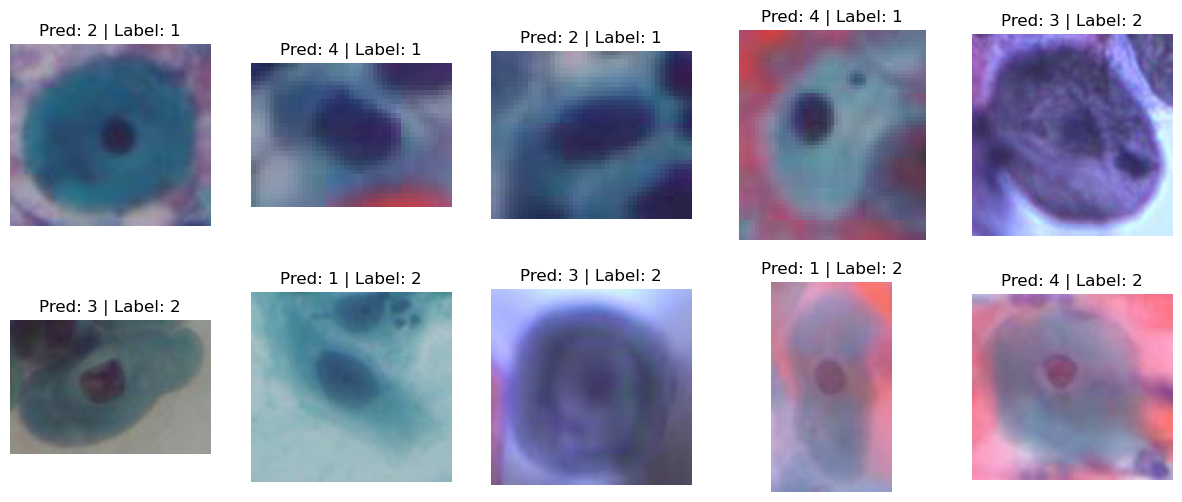

In [65]:
# Find the misclassified samples
misclassified = []
for i in range(len(test_labels)):
    if test_labels[i] != test_preds[i]:
        misclassified.append(i)
# Plot the misclassified samples
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    # Get the image
    img = Image.open(test_paths[misclassified[i]])
    # Plot the image
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].set_title(f'Pred: {test_preds[misclassified[i]]} | Label: {test_labels[misclassified[i]]}')
    axs[i//5, i%5].axis('off')